In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('daily-maximum-temperatures-in-me.csv')

In [3]:
df.head()

,date,max_temp
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5
3,1981-01-04,20.7
4,1981-01-05,21.5


In [4]:
raw_data = df.max_temp.values

In [5]:
raw_data[:10]

array([ 38.1,  32.4,  34.5,  20.7,  21.5,  23.1,  29.7,  36.6,  36.1,  20.6])

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
raw_data = scaler.fit_transform(raw_data.reshape(-1,1))

In [7]:
len(raw_data)

3650

In [8]:
timestep = 5
X = []
Y = []
for i in range(len(raw_data)-(timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])

In [9]:
X = np.asanyarray(X)
X = X.reshape((X.shape[0],X.shape[1],1))

In [10]:
Y = np.asanyarray(Y)

In [11]:
len(Y)

3645

In [12]:
k = int(0.7*len(Y))
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]

In [13]:
Ytrain = Y[:k]
Ytest = Y[k:]

In [14]:
model = Sequential()
model.add(LSTM(64,batch_input_shape=(None,timestep,1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 64)             16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(Xtrain,
          Ytrain,
          batch_size=20,
          validation_data=(Xtest,Ytest),
          verbose=1,
          epochs=30,
          shuffle=False)

/usr/local/lib/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2551 samples, validate on 1094 samples
Epoch 1/30
2551/2551 [==============================] - 3s - loss: 0.0255 - val_loss: 0.0235

In [17]:
def insert_end(Xin,new_input):
    print('Before: \n', Xin , new_input) 
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    print('After :\n', Xin)
    return Xin

In [18]:
beg = random.randint(0,len(Ytest)-100)
forcasted_output = []
Xin = Xtest[beg:beg+1,:,:]
for i in range(100):
    out = model.predict(Xin, batch_size=1)    
    forcasted_output.append(out[0,0])
    Xin = insert_end(Xin,out[0,0])
forcasted_output = scaler.inverse_transform(forcasted_output)

Before: 
 [[[ 0.40495868]
  [ 0.34435262]
  [ 0.49035813]
  [ 0.63911846]
  [ 0.67768595]]] 0.520809
After :
 [[[ 0.34435262]
  [ 0.49035813]
  [ 0.63911846]
  [ 0.67768595]
  [ 0.52080905]]]
Before: 
 [[[ 0.34435262]
  [ 0.49035813]
  [ 0.63911846]
  [ 0.67768595]
  [ 0.52080905]]] 0.451136
After :
 [[[ 0.49035813]
  [ 0.63911846]
  [ 0.67768595]
  [ 0.52080905]
  [ 0.4511365 ]]]
Before: 
 [[[ 0.49035813]
  [ 0.63911846]
  [ 0.67768595]
  [ 0.52080905]
  [ 0.4511365 ]]] 0.450575
After :
 [[[ 0.63911846]
  [ 0.67768595]
  [ 0.52080905]
  [ 0.4511365 ]
  [ 0.45057514]]]
Before: 
 [[[ 0.63911846]
  [ 0.67768595]
  [ 0.52080905]
  [ 0.4511365 ]
  [ 0.45057514]]] 0.464061
After :
 [[[ 0.67768595]
  [ 0.52080905]
  [ 0.4511365 ]
  [ 0.45057514]
  [ 0.46406102]]]
Before: 
 [[[ 0.67768595]
  [ 0.52080905]
  [ 0.4511365 ]
  [ 0.45057514]
  [ 0.46406102]]] 0.468341
After :
 [[[ 0.52080905]
  [ 0.4511365 ]
  [ 0.45057514]
  [ 0.46406102]
  [ 0.46834075]]]
Before: 
 [[[ 0.52080905]
  [ 0.4511365 

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Plotting Results


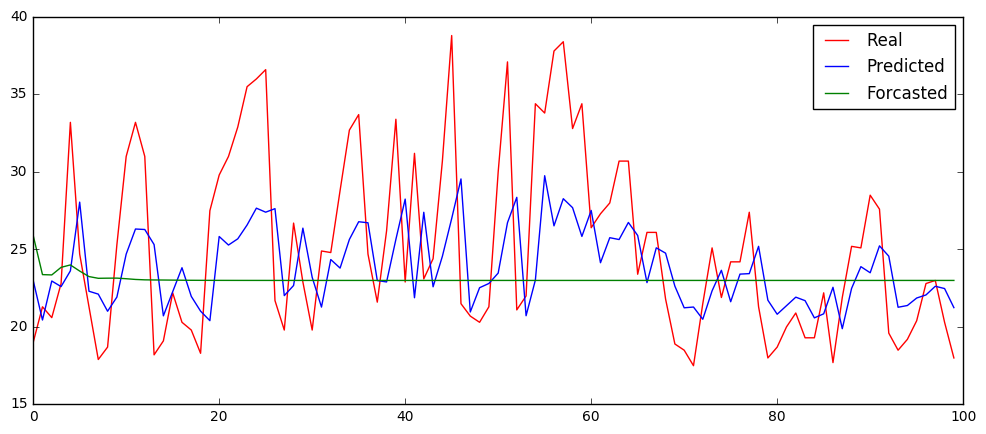

In [19]:
selected_input = Xtest[beg:beg+100,:,:]
real_output = scaler.inverse_transform(Ytest[beg:beg+100])
predicted_output = model.predict(selected_input, batch_size=1)
predicted_output = scaler.inverse_transform(predicted_output)
print('Plotting Results')
plt.figure(figsize=(12,5))
xpos = range(len(predicted_output))
plt.plot(xpos,real_output,'r',xpos,predicted_output,'b',xpos,forcasted_output,'g')
plt.legend(('Real','Predicted','Forcasted'))
plt.savefig('out.jpg',dpi=400)
plt.show()